### модель классификации интентов на основе сущностей, целей и фраз 

Данильченко Вадим

In [4]:
import pandas as pd
from tqdm import trange, tqdm
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import TimeDistributed, Embedding, LSTM, Bidirectional, Dropout, Dense

In [217]:
data = pd.read_excel('goal_ent_train.xlsx')
data.head()

,intent_id,goal,message,group,target_entities,new_entities,error,bad
0,gi074,11,"не знаю , как сменить данные паспорта . новые ...",Изменение персональных данных,O O B-QUESTION B-ACT B-DAT I-DAT B-FEAT_VAL B-...,NaN,NaN,NaN
1,gi081,44,есть ли среди партнеров по карте свобода компа...,Информация по продукту,O O O B-ROLE O B-PRODUCT I-PRODUCT O B-STATE_A...,NaN,NaN,NaN
2,gi144,7,сумму для полного досрочного погашения № 22770...,ПДП/ЧДП,B-FEAT O B-FEAT_VAL I-FEAT_VAL B-SITUATION B-R...,NaN,NaN,NaN
3,gi169,34;16;6,почему я не могу оплатить кредит ? что значит ...,Проблема с оплатой/счетом/поступлением платежа,B-QUESTION O O O B-ACT B-PRODUCT B-QUESTION O ...,NaN,NaN,NaN
4,gi377,27;7,"куда я могу написать заявление претензию , жал...",Пообщаться с оператором,B-QUESTION O O O B-DOC B-FEEDBACK I-FEEDBACK O...,NaN,NaN,NaN


In [6]:
targets = pd.read_excel('цели.xlsx')
targets.head()

,номер,цель
0,0,заблокировать
1,1,разблокировать
2,2,пополнить
3,3,"аннулировать, отказаться"
4,4,как избежать чего-либо


In [7]:
words = []
for i in trange(data.shape[0]):
    for j in data.loc[i, 'message'].split(' '):
        words.append(j)
words = list(set(words))
words[:3]

100%|██████████████████████████████████████████████████████████████████████| 113324/113324 [00:01<00:00, 112878.33it/s]


['вышеуказанныи', 'петербурга', '501']

In [8]:
# создадим словари для слов предложения
word2id = {}
for k,v in tqdm(enumerate(words)):
    if v not in word2id:
        word2id[v] = k+2
    
# word2id = {v:k+2 for k,v in enumerate(words)}
word2id['unk'] = 1

id2word = {v:k for k,v in word2id.items()}

19484it [00:00, 1354669.95it/s]


In [9]:
# преобразуем предложения в последовательность индексов слов
X = [[] for _ in trange(data.shape[0])]
for i in trange(data.shape[0]):
    sentence = data.loc[i, 'message'].split(' ')
    for word in sentence:
        X[i].append(word2id[word])
# X = [word2id[word] for word in [sentence.split(' ') for sentence in final_file_entities['text']]]
X[:2]

100%|██████████████████████████████████████████████████████████████████████| 113324/113324 [00:01<00:00, 104275.12it/s]


[[1674,
  12971,
  12061,
  3413,
  13778,
  14809,
  1628,
  1666,
  8367,
  14809,
  5272,
  19337,
  11611],
 [13349,
  13793,
  1802,
  2652,
  14859,
  9714,
  17766,
  6284,
  12061,
  8261,
  12061,
  16668,
  7667,
  10010,
  7565,
  3828,
  15235]]

In [10]:
# посчитаем максимальную длину текста
max_len = 0
for i in X:
    if len(i)>max_len:
        max_len = len(i)
max_len

96

In [11]:
# добавим нули до макисмального размера последовательности
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=0)
X[:2]

array([[ 1674, 12971, 12061,  3413, 13778, 14809,  1628,  1666,  8367,
        14809,  5272, 19337, 11611,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [13349, 13793,  1802,  2652, 14859,  9714, 17766,  6284, 12061,
         8261, 12061, 16668,  7667, 10010,  7565,  3828, 15235,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     

In [12]:
labels = []
for i in trange(data.shape[0]):
    for j in data.loc[i, 'target_entities'].split(' '):
        labels.append(j)
labels = list(set(labels))
labels[:3]

100%|██████████████████████████████████████████████████████████████████████| 113324/113324 [00:00<00:00, 125838.47it/s]


['I-PRODUCT', 'B-SUM', 'B-SERVICE']

In [13]:
# создадим словари для тэгов сущностей
tag2id = {'O':0}
for k,v in tqdm(enumerate(labels)):
    if v not in tag2id:
        tag2id[v] = k+1
    
id2tag = {v:k for k,v in tag2id.items()}

75it [00:00, 151091.64it/s]


In [14]:
y = [[] for _ in range(data.shape[0])]
for i in trange(data.shape[0]):
    sentence = data.loc[i, 'target_entities'].split(' ')
    for word in sentence:
        y[i].append(tag2id[word])

# y = [[tag2idx[w[2]] for w in s] for s in sentences]
y[:2]

100%|██████████████████████████████████████████████████████████████████████| 113324/113324 [00:00<00:00, 117586.06it/s]


[[0, 0, 60, 39, 37, 40, 11, 37, 6, 57],
 [0, 0, 0, 42, 0, 32, 1, 0, 22, 11, 0, 0, 0, 29]]

In [15]:
# запишем в целевую переменную индексы тэгов каждого предложения

y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2id["O"])
y[:2]

array([[ 0,  0, 60, 39, 37, 40, 11, 37,  6, 57,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 42,  0, 32,  1,  0, 22, 11,  0,  0,  0, 29,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [16]:
# преобразуем y в категориальный вид
# y_train_cat = [to_categorical(i, num_classes=max(tag2id.values())) for i in y_train]
y_cat= []
for i in tqdm(y):
    try:
        y_cat.append(to_categorical(i, num_classes=max(tag2id.values())))
    except:
        y_cat.append(to_categorical(np.zeros((len(y[0])), dtype='int'), num_classes=max(tag2id.values())))
        
y_cat = np.asarray(y_cat)
y_cat[:2]

100%|███████████████████████████████████████████████████████████████████████| 113324/113324 [00:03<00:00, 35321.48it/s]


array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [17]:
# разделим данные на тренировочную и валидационную выборки
x_train, x_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.1, random_state=777)

In [18]:
max_len

96

In [19]:
len(tag2id)

75

In [20]:
max(tag2id.values())

75

In [21]:
from keras.models import Model
from keras.layers import Input

In [22]:
inp = Input(shape=(max_len))
emb = Embedding(input_dim=len(word2id)+1, output_dim=100, input_length=max_len, name='embedding')(inp)
x = Bidirectional(LSTM(100, return_sequences=True, recurrent_dropout=0.1, name='bi_lstm'))(emb)
x = Dropout(0.1)(x)
out = TimeDistributed(Dense(max(tag2id.values()), activation='softmax', name='dense'))(x)

model = Model(inp,out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 96, 100)           1948600   
_________________________________________________________________
bidirectional (Bidirectional (None, 96, 200)           160800    
_________________________________________________________________
dropout (Dropout)            (None, 96, 200)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 96, 75)            15075     
Total params: 2,124,475
Trainable params: 2,124,475
Non-trainable params: 0
_________________________________________________________________


In [25]:
from keras.optimizers import Adam

In [28]:
model.compile(optimizer=Adam(learning_rate=0.001)
              ,loss='categorical_crossentropy'
              ,metrics=['accuracy']
             )

In [29]:
history = model.fit(x_train, 
                    y_train, 
                    batch_size=256, 
                    epochs=2, 
                    validation_data=(x_test,y_test),
#                     validation_split=0.1, 
                    verbose=1)

Epoch 1/2
399/399 [==============================] - 453s 1s/step - loss: 0.1679 - accuracy: 0.9717 - val_loss: 0.1040 - val_accuracy: 0.9776
Epoch 2/2
399/399 [==============================] - 300s 753ms/step - loss: 0.0825 - accuracy: 0.9818 - val_loss: 0.0644 - val_accuracy: 0.9862


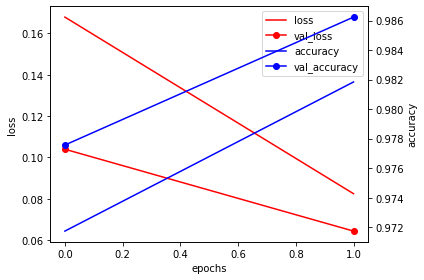

In [30]:
import matplotlib.pyplot as plt
# посмотрим на историю обучения

fig, ax1 = plt.subplots()

t = np.arange(0, len(history.history['accuracy']), 1)

ln1 = ax1.plot(t, history.history['loss'], color='r', label='loss')
ln2 = ax1.plot(t, history.history['val_loss'], color='r', marker='o', label='val_loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
# ax1.legend(loc=0)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ln3 = ax2.plot(t, history.history['accuracy'], color='b', label='accuracy')
ln4 = ax2.plot(t, history.history['val_accuracy'], color='b', marker='o', label='val_accuracy')
ax2.set_ylabel('accuracy')  # we already handled the x-label with ax1
# ax2.legend(loc=0)

lns = ln1+ln2+ln3+ln4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.legend(loc='lower right')
plt.show()

In [31]:
model.save('NER_predict.h5')

предикт

In [55]:
# функция векторизации
def vectorize(text):
    text = text.split(' ')
    sentence = []
    for word in text:
        sentence.append(word2id[word])
        
    return pad_sequences(sequences=[sentence], maxlen=max_len, padding='post', value=0)

vectorize('lamoda является партнером по рассрочка ?')

array([[19403,  9904, 11389, 14859,   377, 15235,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]])

In [69]:
model.predict(vectorize('lamoda является партнером по рассрочка ?')).shape

(1, 96, 75)

In [74]:
np.argmax(model.predict(vectorize('lamoda является партнером по рассрочка ?')), axis=2)

array([[ 0,  0,  0,  0, 32,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
      dtype=int64)

In [78]:
for i in np.argmax(model.predict(vectorize('lamoda является партнером по рассрочка ?')), axis=2)[0]:
    print(i, id2tag[i])

0 O
0 O
0 O
0 O
32 B-PRODUCT
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O
0 O


далее подаем предикт в id на вход совместной с целями сетке

### модель классификации интентов 

In [122]:
import pymorphy2, joblib, re
from keras.preprocessing.text import text_to_word_sequence


morph = pymorphy2.MorphAnalyzer()

# nltk.download("stopwords")

# подгрузим стоп-слова
try:
    russian_stopwords = stopwords.words("russian")
except:
    russian_stopwords=joblib.load('russian_stopwords.pkl')


stop_words=['нахер', 'третье', 'кола', 'жаль','который', 'кпникула' , 'мегодень', 'каедомлентить', 'точнуб', 'закасить',\
           'лайна', 'вслехать', 'нат', 'кроме', 'срочно', 'ередить', 'блчдь', 'могуля', 'пиздец', 'копа', 'бэкома', 'ирек',\
           'каклть', 'хрень', 'нахер', 'таки', 'никто', 'муха', 'сраный', 'туда', 'слушай', 'долдно', 'каков', 'как', 'какой',\
           'блядь', 'горелый', 'можито', 'пора', 'недолжный', 'это', 'ваш' , 'nan', 'косасия' ,'пидар', 'пидра', 'понос' ,\
            'отъестись', 'нибыть', 'вообще', 'видимо', 'позвать', 'назад', 'иметь', 'ввиду', 'добрый']

add2stop_words=['подскажите', 'подсказать', 'пожалуйста', 'необходимо', 'здравствуйте', 'скажите', 'пожалуйста',
                'хочу', 'почему', 'привет']

russian_stopwords=russian_stopwords + stop_words + add2stop_words

# исключим из словаря некоторые слова
excl_from_dict=['как', 'какой', 'иметь', 'который', 'какая', 'нет', 'было', 'быть', 'ничего',
                'где', 'куда', 'зачем', 'не', 'можно']

russian_stopwords=list(set([i for i in russian_stopwords if i not in excl_from_dict]))

# список приветственных словосочетаний, которые исключим из предложения
del_from_sentence=['добрый день', 'добрый вечер', 'просьба подсказать', 'доброго времени', 'доброй ночи', 'доброе время суток', \
                   'день добрый', 'доброго времени', 'доброго дня', 'вечер добрый', 'утро доброе', 'подскажите пожалуйста']

# скорректируем опечатки
errors=joblib.load('errors2correct_dict.pkl')

def preprocess_text(text):
    text = str(text).lower().strip()
    text = text.replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я0-9?!]+', ' ', text) 
#     text = re.sub(' +', ' ', text)
    text = re.sub(r'[^\w\s\d?!]+', ' ',text)
    obj = re.match(r'[\d+\W+?!]{,}', text)
    text = text[0 if obj is None else len(obj.group(0)):]    
    text = re.sub(r'[\s+]&&[^?!]', ' ', text)
    text = re.sub('([a-zа-яёе0-9?!])\1{2,}', r'\1\1', text)  # aaaaa -> aa
    text = re.sub(r'([^a-zа-яёе0-9?!])\1{1,}', r'\1', text)  # )))) -> )
#     text = re.sub(r'([^0-9]|^)([%s]+)([^0-9]|$)' % string.punctuation, r'\1 \2 \3', text)
#     try:
#         text=[text.replace(phrase, ' ') for phrase in del_from_sentence if phrase in text][0].strip()
#     except:
#         text=text
    
#     if len(text)==1:
#         tokens = text.strip()
#     else:
#         tokens = text.split()
        
#     tokens = [morph.parse(token.strip())[0].normal_form for token in tokens if len(token.strip())>0\
#              and token.strip() not in russian_stopwords]
    tokens = text_to_word_sequence(text)
    tokens_result=[]
    for token in tokens:
        if len(token.strip())>0 and token.strip() not in russian_stopwords:
            token=morph.parse(token.strip())[0].normal_form
            if token in errors.keys():
                tokens_result.append(errors[token])
            else:
                tokens_result.append(token)
            
#               and token.strip() not in punctuation]
    
    return tokens_result

preprocess_text('lamoda является партнером по рассрочка ?')

['lamoda', 'являться', 'партнёр', 'рассрочка']

In [123]:
sentences = []
for i in trange(data.shape[0]):
    sentences.append(preprocess_text(data['message'].iloc[i]))
sentences[:2]

100%|████████████████████████████████████████████████████████████████████████| 113324/113324 [01:22<00:00, 1380.76it/s]


[['не',
  'знать',
  'как',
  'сменить',
  'дать',
  'паспорт',
  'новый',
  'дать',
  '0319',
  '436622'],
 ['среди',
  'партнёр',
  'карта',
  'свобода',
  'компания',
  'устанавливать',
  'пластиковый',
  'окно',
  'нижний',
  'новгород']]

In [127]:
from keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer()

In [128]:
maxlen = 500 

tokenizer = Tokenizer(num_words=maxlen, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(sentences)         
items = list(tokenizer.word_index.items())
items[:2]

[('unknown', 1), ('карта', 2)]

In [129]:
sequences = tokenizer.texts_to_sequences(sentences)
sequences[:2]

[[4, 344, 5, 242, 116, 291, 19, 116, 1, 1], [1, 101, 2, 27, 1, 1, 1, 1, 1, 1]]

In [130]:
# преобразуем в one hot encoding формат
xTrainRez01 = tokenizer.sequences_to_matrix(sequences) 
print(xTrainRez01.shape)                                      
print(xTrainRez01[0][0:100])

(113324, 500)
[0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [134]:
classes = data['intent_id'].unique().tolist()
print(len(classes))
classes[:2]

384


['gi074', 'gi081']

In [135]:
data['target'] = data['intent_id'].astype('category').cat.codes
data['target'][:10]

0     70
1     77
2    136
3    159
4    347
5    347
6    313
7    330
8    137
9    157
Name: target, dtype: int16

In [136]:
y = data['target'].tolist()
y[:20]

[70,
 77,
 136,
 159,
 347,
 347,
 313,
 330,
 137,
 157,
 157,
 223,
 317,
 369,
 317,
 72,
 301,
 210,
 334,
 237]

In [137]:
y_cat = to_categorical(y)
np.asarray(y_cat).shape

(113324, 384)

In [138]:
x_train, x_test, y_train, y_test = train_test_split(np.asarray(xTrainRez01), np.asarray(y_cat), test_size=0.1, random_state=777, shuffle= True)

In [140]:
from keras.layers import BatchNormalization

In [146]:
inp = Input(shape=(500, ))
# x = BatchNormalization()(inp)
x = Dense(800, activation='relu')(inp)
x = Dropout(0.3)(x)
x = Dense(600, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(400, activation='relu')(x)
output = Dense(len(classes), activation='softmax')(x)
model = Model(inp, output)

model.compile(optimizer=Adam(lr=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

history = model.fit(x_train, 
                    y_train, 
                    batch_size=256,
                    epochs=10, 
                    validation_data=(x_test, y_test),
                    verbose=1, shuffle=True)

Epoch 1/10
399/399 [==============================] - 8s 19ms/step - loss: 0.4022 - accuracy: 0.8833 - val_loss: 0.4224 - val_accuracy: 0.8823
Epoch 2/10
399/399 [==============================] - 8s 19ms/step - loss: 0.3928 - accuracy: 0.8856 - val_loss: 0.4217 - val_accuracy: 0.8810
Epoch 3/10
399/399 [==============================] - 8s 19ms/step - loss: 0.3888 - accuracy: 0.8867 - val_loss: 0.4196 - val_accuracy: 0.8848
Epoch 4/10
399/399 [==============================] - 8s 19ms/step - loss: 0.3814 - accuracy: 0.8885 - val_loss: 0.4156 - val_accuracy: 0.8847
Epoch 5/10
399/399 [==============================] - 8s 19ms/step - loss: 0.3724 - accuracy: 0.8902 - val_loss: 0.4179 - val_accuracy: 0.8831
Epoch 6/10
399/399 [==============================] - 8s 19ms/step - loss: 0.3679 - accuracy: 0.8921 - val_loss: 0.4113 - val_accuracy: 0.8833
Epoch 7/10
399/399 [==============================] - 8s 19ms/step - loss: 0.3623 - accuracy: 0.8930 - val_loss: 0.4120 - val_accuracy: 0.8837

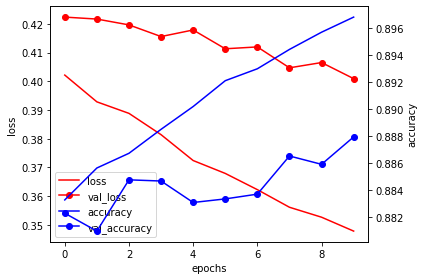

In [149]:
import matplotlib.pyplot as plt
# посмотрим на историю обучения

fig, ax1 = plt.subplots()

t = np.arange(0, len(history.history['accuracy']), 1)

ln1 = ax1.plot(t, history.history['loss'], color='r', label='loss')
ln2 = ax1.plot(t, history.history['val_loss'], color='r', marker='o', label='val_loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
# ax1.legend(loc=0)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ln3 = ax2.plot(t, history.history['accuracy'], color='b', label='accuracy')
ln4 = ax2.plot(t, history.history['val_accuracy'], color='b', marker='o', label='val_accuracy')
ax2.set_ylabel('accuracy')  # we already handled the x-label with ax1
# ax2.legend(loc=0)

lns = ln1+ln2+ln3+ln4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.legend(loc='lower right')
plt.show()

In [151]:
from sklearn.metrics import f1_score

In [152]:
f1_score(y, np.argmax(model.predict(np.asarray(xTrainRez01)), axis=1), average='micro')

0.9142900003529703

In [153]:
model.save('model_intent.h5')

### модель по определению целей

План

1. препроцессинг фраз с нормализацией
2. векторизация word2vec
3. pad_sequences
4. модель
5. оценка качества 
6. predict

In [124]:
from gensim.models import Word2Vec

In [126]:
wvec = Word2Vec(sentences, workers=-1, min_count=1, window=6, size=200)

10363

In [290]:
word2id_wvec = {i:k+2 for k,i in enumerate(wvec.wv.vocab.keys())}
word2id_wvec['UNK'] = 1
id2word_wvec = {k:i for i,k in word2id_wvec.items()}

In [293]:
len(word2id_wvec)

10364

In [294]:
embed_matrix = np.zeros((len(word2id_wvec)+1, wvec.wv.vector_size))
embed_matrix.shape

(10365, 200)

In [346]:
for i in id2word_wvec.keys():
    if i == 0:
        embed_matrix[i] = np.zeros(wvec.wv.vector_size)
    elif i==1:
        embed_matrix[i] = [0.0001]*wvec.wv.vector_size
    else:
        embed_matrix[i] = wvec.wv.__getitem__(id2word_wvec[i])
#     if id2word_wvec[i] in wvec:
#         embed_matrix[i] = wvec.wv.__getitem__(id2word_wvec[i])
#     else:
#         embed_matrix[i] = np.zeros(wvec.wv.vector_size)
      

In [347]:
sequences_wvec = [[] for _ in range(len(sentences))]
for i in trange(len(sentences)):
    for word in sentences[i]:
        sequences_wvec[i].append(word2id_wvec[word])
sequences_wvec[:2]

100%|██████████████████████████████████████████████████████████████████████| 113324/113324 [00:00<00:00, 677969.08it/s]


[[2, 3, 4, 5, 6, 7, 8, 6, 9, 10], [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]

In [348]:
max_len_wvec = 0
for i in trange(len(sequences_wvec)):
    tmp_max = len(sequences_wvec[i])
    if tmp_max>max_len_wvec:
        max_len_wvec=tmp_max
        
max_len_wvec

100%|█████████████████████████████████████████████████████████████████████| 113324/113324 [00:00<00:00, 1936174.32it/s]


60

In [349]:
sequences_wvec_pad = [pad_sequences([seq], maxlen=max_len_wvec, padding='post', value=0) for seq in sequences_wvec]
sequences_wvec_pad[:2]

[array([[ 2,  3,  4,  5,  6,  7,  8,  6,  9, 10,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]),
 array([[11, 12, 13, 14, 15, 16, 17, 18, 19, 20,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])]

In [350]:
embed_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e-04,  1.00000000e-04,  1.00000000e-04, ...,
         1.00000000e-04,  1.00000000e-04,  1.00000000e-04],
       [ 3.78858007e-04, -5.39299392e-04, -1.35365839e-03, ...,
        -6.53699331e-04, -2.75202590e-04,  9.37185541e-04],
       ...,
       [ 5.94565819e-04, -2.14231294e-03,  2.26941635e-03, ...,
        -2.15624645e-03,  1.92471233e-03,  1.13999587e-03],
       [-1.16165240e-04,  3.31216492e-04, -2.24306528e-03, ...,
         1.58834469e-03,  1.71516137e-03, -2.46966584e-03],
       [-2.14764848e-03,  2.26402446e-03,  1.16921205e-03, ...,
        -2.44116201e-03, -5.58515370e-04, -1.21127414e-05]])

In [351]:
# таргет
targets_len = max(targets['номер'].tolist())
targets_len

104

In [352]:
y_wvec = [np.zeros(targets_len+2) for _ in range(len(sentences))]
for i in trange(len(sentences)):
    tmp_sent = re.sub(r'[^\d;]','', data['goal'].iloc[i]).split(';') if isinstance(data['goal'].iloc[i], str) else [data['goal'].iloc[i]]
    for j in tmp_sent:
        if j:
            y_wvec[i][int(j)] = 1
            
y_wvec = np.asarray(y_wvec)
print(y_wvec[:2])

sequences_wvec_pad = [i[0] for i in sequences_wvec_pad]

100%|███████████████████████████████████████████████████████████████████████| 113324/113324 [00:01<00:00, 60744.01it/s]


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [354]:
x_train_w, x_test_w, y_train_w, y_test_w = train_test_split(np.asarray(sequences_wvec_pad), y_wvec, test_size=0.1, random_state=777)

In [355]:
x_train_w[:2]

array([[ 125,  150,  108,  373,  448,  307,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [2633,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0]])

In [356]:
y_train_w[:2]

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [371]:
from keras.layers import Flatten
from tensorflow.keras import backend as K

In [372]:
max_len_wvec

In [395]:
inp = Input(shape=(max_len_wvec,))

embedding_layer = Embedding(len(word2id_wvec)+1, 
                            output_dim = wvec.wv.vector_size,
                            input_length=max_len_wvec,
                            trainable=True,
                            weights=[embed_matrix]
                           )(inp)

x = LSTM(200, return_sequences=True, name='lstm_1')(embedding_layer)
x = LSTM(150, return_sequences=True, name='lstm_2')(x)
x = Dense(400, name='dense_1')(x)
x = Dropout(0.3)(x)
x = Dense(100,  name='dense_2')(x)
x = Flatten()(x)
x = Dense(4096,  name='dense_3')(x)
x = Dropout(0.2)(x)
x = Dense(2048,  name='dense_4')(x)
x = Dense(512,  name='dense_5')(x)
output = Dense(targets_len+2, activation='softmax', name='dense_output')(x)
model = Model(inp, output)
model.compile(loss=ovsr_binary_crossentropy,
             optimizer=Adam(learning_rate=0.001),
             metrics=['accuracy'])

model.summary()

Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        [(None, 60)]              0         
_________________________________________________________________
embedding_38 (Embedding)     (None, 60, 200)           2073000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 200)           320800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 150)           210600    
_________________________________________________________________
dense_1 (Dense)              (None, 60, 400)           60400     
_________________________________________________________________
dropout_60 (Dropout)         (None, 60, 400)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 60, 100)           401

In [396]:
model.fit(x_train_w, 
          y_train_w,
          epochs=10,
          batch_size=512,
          validation_data=(x_test_w, y_test_w),
#           validation_split=0.1,
          verbose=1,
          shuffle=True
        )

Epoch 1/10
200/200 [==============================] - 405s 2s/step - loss: 0.0338 - accuracy: 0.4416 - val_loss: 0.0195 - val_accuracy: 0.6689
Epoch 2/10
200/200 [==============================] - 416s 2s/step - loss: 0.0165 - accuracy: 0.7305 - val_loss: 0.0154 - val_accuracy: 0.7549
Epoch 3/10
200/200 [==============================] - 430s 2s/step - loss: 0.0134 - accuracy: 0.7745 - val_loss: 0.0140 - val_accuracy: 0.7637
Epoch 4/10
200/200 [==============================] - 429s 2s/step - loss: 0.0120 - accuracy: 0.7926 - val_loss: 0.0139 - val_accuracy: 0.7645
Epoch 5/10
200/200 [==============================] - 429s 2s/step - loss: 0.0111 - accuracy: 0.8053 - val_loss: 0.0128 - val_accuracy: 0.7806
Epoch 6/10
200/200 [==============================] - 434s 2s/step - loss: 0.0104 - accuracy: 0.8127 - val_loss: 0.0128 - val_accuracy: 0.7818
Epoch 7/10
200/200 [==============================] - 438s 2s/step - loss: 0.0100 - accuracy: 0.8188 - val_loss: 0.0124 - val_accuracy: 0.7917

In [397]:
model.save('model_goals.h5')

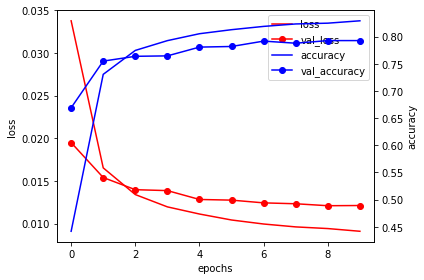

In [398]:
import matplotlib.pyplot as plt
# посмотрим на историю обучения
history = model.history

fig, ax1 = plt.subplots()

t = np.arange(0, len(history.history['accuracy']), 1)

ln1 = ax1.plot(t, history.history['loss'], color='r', label='loss')
ln2 = ax1.plot(t, history.history['val_loss'], color='r', marker='o', label='val_loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
# ax1.legend(loc=0)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ln3 = ax2.plot(t, history.history['accuracy'], color='b', label='accuracy')
ln4 = ax2.plot(t, history.history['val_accuracy'], color='b', marker='o', label='val_accuracy')
ax2.set_ylabel('accuracy')  # we already handled the x-label with ax1
# ax2.legend(loc=0)

lns = ln1+ln2+ln3+ln4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.legend(loc='lower right')
plt.show()

In [399]:
y_pred = model.predict(x_test_w)
f1_score(np.argmax(y_test_w, axis=1), np.argmax(y_pred, axis=1), average='micro')

0.7926409600282361

In [ ]:
sentence = 'lamoda является партнером банка'
sentence_pad = pad_sequences([sentence], maxlen=max_len_wvec, padding='post', value=0)
    for word in sentences[i]:
        sequences_wvec[i].append(word2id_wvec[word])

### объединим 3 модели

1. на вход будут предикт модели сущностей, предикт модели целей и вектор фразы


подготовим данные для обучения на основе сущностей, предикт будет выступать как вектор входящих данных для модели интентов

In [385]:
from keras.models import load_model

In [388]:
model_ner = load_model('NER_predict.h5')

In [389]:
# функция векторизации
def vectorize(text):
    text = text.split(' ')
    sentence = []
    for word in text:
        if word not in word2id:
            word = 'UNK'
        sentence.append(word2id[word])
        
    return pad_sequences(sequences=[sentence], maxlen=max_len, padding='post', value=0)

vectorize('lamoda является партнером по рассрочка ?')

array([[19403,  9904, 11389, 14859,   377, 15235,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]])

In [402]:
np.argmax(model_ner.predict(vectorize('lamoda является партнером по рассрочка ?')), axis=2)

array([[ 0,  0,  0,  0, 32,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
      dtype=int64)

In [400]:
X

array([[ 1674, 12971, 12061, ...,     0,     0,     0],
       [13349, 13793,  1802, ...,     0,     0,     0],
       [12272,  2609, 11283, ...,     0,     0,     0],
       ...,
       [ 1674,  3224,     0, ...,     0,     0,     0],
       [ 1819, 17980, 15364, ...,     0,     0,     0],
       [ 2891, 19088,  7830, ...,     0,     0,     0]])

In [403]:
# np.argmax(model.predict(vectorize('lamoda является партнером по рассрочка ?')), axis=2)
y_pred_ner = np.argmax(model_ner.predict(X), axis=2)
y_pred_ner[:2]

array([[ 0,  0, 60, 60, 39, 37, 37,  0,  3, 37,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 32,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
      dtype=int64)

2. подготовим предсказание целей - вектор вероятностей предсказания целей будет использоваться как второй вход в сеть предсказания интентов

In [405]:
model_goal = load_model('model_goals.h5', custom_objects={'ovsr_binary_crossentropy': ovsr_binary_crossentropy})

In [412]:
y_pred_goal = model_goal.predict(np.asarray(sequences_wvec_pad))
y_pred_goal[:2]

array([[3.32941461e-08, 2.06779816e-07, 3.16762709e-07, 2.36141977e-06,
        2.67533384e-10, 3.31818732e-08, 4.11954807e-06, 1.66103541e-06,
        6.25863152e-07, 1.54756416e-10, 9.63056026e-16, 9.99401093e-01,
        3.27830530e-05, 3.65107802e-08, 1.81049566e-12, 3.39566611e-07,
        1.11713678e-04, 1.58903174e-06, 6.01641696e-05, 4.88628393e-06,
        3.03009784e-07, 1.01034414e-09, 2.24591844e-07, 1.77202697e-08,
        3.00430486e-07, 3.60992931e-06, 1.98028420e-08, 8.49692372e-10,
        1.45392476e-09, 6.99105271e-08, 2.61866006e-07, 7.87964902e-11,
        1.13170024e-07, 4.13894412e-07, 2.52909189e-07, 1.99399136e-10,
        1.23954247e-04, 9.54295398e-09, 3.22877391e-10, 5.43455542e-07,
        6.95670355e-13, 1.69595012e-07, 1.98794177e-14, 4.56085490e-06,
        9.76299879e-13, 2.44321882e-07, 1.76947884e-04, 9.05102115e-06,
        4.36155823e-08, 3.41091688e-09, 1.54095483e-06, 5.41973354e-14,
        8.02899535e-07, 5.19562633e-08, 2.83536461e-09, 2.360500

3. подготовим модель предсказания интентов, где на вход будут приходить:


* предсказанные сущности на каждую фразу
* вектор вероятностей пресказания тематики
* эмбеддинг предложения Word2Vec по индексам фраз

по итогам результат будет конкатенироваться и подаваться на полносвязный слой с последующей классификациое интентов

In [419]:
xTrainRez01[0][:100]

array([0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [415]:
classes[:2]

['gi074', 'gi081']

In [417]:
y[:5]

[70, 77, 136, 159, 347]

In [418]:
y_cat[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

разобьем данные трех моделей на тренировочную и тестовую выборки 

In [422]:
y_pred_ner.shape

(113324, 96)

In [423]:
y_pred_goal.shape

(113324, 106)

In [425]:
np.asarray(xTrainRez01).shape

(113324, 500)

In [428]:
from keras.layers import Concatenate

In [430]:
# ner
inp_ner = Input(shape=(y_pred_ner.shape[1]))
ner = Dense(y_pred_ner.shape[1]*3, name='dense_1_ner')(inp_ner)
ner = Dropout(0.3)(ner)
ner = Dense(y_pred_ner.shape[1]*2, name='dense_2_ner')(ner)



# goal
inp_goal = Input(shape=(y_pred_goal.shape[1]))
goal = Dense(y_pred_goal.shape[1]*3, name='dense_1_goal')(inp_goal)
goal = Dropout(0.3)(goal)
goal = Dense(y_pred_goal.shape[1]*2, name='dense_2_goal')(goal)


# фразы
inp_phrase = Input(shape=(500, ))
# x = BatchNormalization()(inp)
x = Dense(800, activation='relu', name='dense_1_x')(inp_phrase)
x = Dropout(0.3)(x)
x = Dense(600, activation='relu', name='dense_2_x')(x)
x = Dropout(0.3)(x)
x = Dense(400, activation='relu', name='dense_3_x')(x)


# concat 3 models
x = Concatenate()([ner, goal, x])
x = Dense(600, activation='relu', name='dense_1_concat')(x)
x = Dropout(0.3)(x)
x = Dense(400, activation='relu', name='dense_2_concat')(x)

output = Dense(len(classes), activation='softmax', name='dense_output')(x)

model = Model([inp_ner, inp_goal, inp_phrase], output)

model.compile(optimizer=Adam(lr=1e-4), 
#                   loss='categorical_crossentropy', 
                  loss=ovsr_binary_crossentropy,
                  metrics=['accuracy'])

In [443]:
history = model.fit([y_pred_ner, y_pred_goal, np.asarray(xTrainRez01)], 
                    y_cat, 
                    batch_size=256,
                    epochs=5, 
#                     validation_data=(x_test, y_test),
                    validation_split=0.1,
                    verbose=1, 
                    shuffle=True)



Epoch 1/5
399/399 [==============================] - 15s 39ms/step - loss: 6.0830e-04 - accuracy: 0.9576 - val_loss: 0.0015 - val_accuracy: 0.9198
Epoch 2/5
399/399 [==============================] - 16s 39ms/step - loss: 5.9713e-04 - accuracy: 0.9584 - val_loss: 0.0015 - val_accuracy: 0.9185
Epoch 3/5
399/399 [==============================] - 15s 39ms/step - loss: 5.9148e-04 - accuracy: 0.9586 - val_loss: 0.0015 - val_accuracy: 0.9194
Epoch 4/5
399/399 [==============================] - 16s 39ms/step - loss: 5.7970e-04 - accuracy: 0.9593 - val_loss: 0.0015 - val_accuracy: 0.9209
Epoch 5/5
399/399 [==============================] - 16s 39ms/step - loss: 5.8604e-04 - accuracy: 0.9592 - val_loss: 0.0015 - val_accuracy: 0.9189


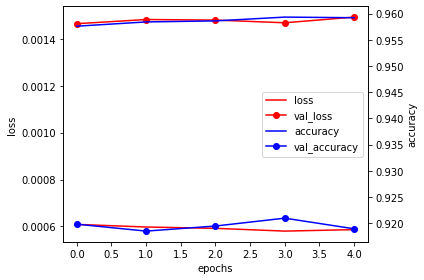

In [444]:
import matplotlib.pyplot as plt
# посмотрим на историю обучения

fig, ax1 = plt.subplots()

t = np.arange(0, len(history.history['accuracy']), 1)

ln1 = ax1.plot(t, history.history['loss'], color='r', label='loss')
ln2 = ax1.plot(t, history.history['val_loss'], color='r', marker='o', label='val_loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
# ax1.legend(loc=0)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ln3 = ax2.plot(t, history.history['accuracy'], color='b', label='accuracy')
ln4 = ax2.plot(t, history.history['val_accuracy'], color='b', marker='o', label='val_accuracy')
ax2.set_ylabel('accuracy')  # we already handled the x-label with ax1
# ax2.legend(loc=0)

lns = ln1+ln2+ln3+ln4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.legend(loc='lower right')
plt.show()

In [433]:
f1_score(y, np.argmax(model.predict([y_pred_ner, y_pred_goal, np.asarray(xTrainRez01)]), axis=1), average='micro')

0.9682238537291307

In [440]:
from sklearn.metrics import classification_report

In [442]:
print(classification_report(y, np.argmax(model.predict([y_pred_ner, y_pred_goal, np.asarray(xTrainRez01)]), axis=1), target_names=classes))

              precision    recall  f1-score   support

       gi074       0.00      0.00      0.00         4
       gi081       0.00      0.00      0.00        12
       gi144       0.94      0.65      0.77       102
       gi169       0.65      0.48      0.55        23
       gi377       0.00      0.00      0.00        20
       gi343       0.00      0.00      0.00        25
       gi360       0.00      0.00      0.00        18
       gi145       0.99      0.99      0.99       211
       gi167       0.95      0.95      0.95       437
       gi236       0.94      1.00      0.97        30
       gi347       0.99      0.95      0.97       429
       gi399       0.97      0.99      0.98       705
       gi076       0.97      0.98      0.98       483
       gi331       0.98      0.99      0.98       356
       gi223       0.71      1.00      0.83         5
       gi364       0.96      1.00      0.98       117
       gi251       0.99      0.98      0.99       303
       gi107       0.97    

C:\Users\vdanilchenko\test-env3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
